## Importing the Dataset

In [1259]:
import numpy as np

In [1260]:
import pandas as pd
df=pd.read_excel("Train.xlsx")
y=df['y']
X=df.drop('y', axis=1)

In [1261]:
X.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome'],
      dtype='object')

In [1262]:
X.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
16106,54,management,married,tertiary,no,122,yes,no,cellular,22,jul,126,3,-1,0,unknown
18365,27,blue-collar,single,secondary,no,677,no,yes,telephone,31,jul,110,8,-1,0,unknown
39356,26,admin.,single,secondary,no,236,yes,yes,cellular,18,may,8,2,-1,0,unknown
39463,54,technician,married,secondary,no,1299,yes,no,cellular,25,may,104,1,-1,0,unknown
27181,34,blue-collar,single,secondary,no,1423,yes,no,cellular,21,nov,55,2,-1,0,unknown


## Data Preprocessing

In [1263]:
l=['age','balance','day','duration','campaign','pdays','previous']
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for column in X.columns:
    if column not in l:
        X[column]=labelencoder.fit_transform(X[column])

In [1264]:
X.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
28296,44,1,2,0,0,287,0,0,0,29,4,301,1,-1,0,3
18528,36,4,1,2,0,3770,1,0,0,31,5,150,4,-1,0,3
10755,35,6,1,2,0,333,0,0,2,17,6,78,5,-1,0,3
34192,36,4,1,2,0,130,0,0,0,4,8,65,1,-1,0,3
39897,55,4,0,2,0,1633,0,0,1,2,6,128,1,-1,0,3


In [1265]:
y=labelencoder.fit_transform(y)

In [1266]:
numerical_list=['age','balance','day','duration','campaign','pdays','previous']

## Important Functions

In [1267]:
def entropy_cal (y):
    sum=np.sum(y)
    if(sum==0 or sum==len(y)):
        return 0
    sum1=len(y)-sum
    return -((sum/len(y))*np.log10((sum/len(y))))-((sum1/len(y))*np.log10((sum1/len(y))))
print(entropy_cal(y))

0.1567256142765696


In [1268]:
def gini_impurity(y):
    if(len(y)==0):
        return 0
    sum=np.sum(y)/len(y)
    sum1=(len(y)-np.sum(y))/len(y)
    return (1-np.power(sum,2)-np.power(sum1,2))
print(gini_impurity(y))

0.20659872015928626


In [1269]:
def information_gain(X,y,feature,threshold,option):
    if option=="entropy":
        entropy=entropy_cal(y)
        if(feature in numerical_list):
            length=(X[feature]<=threshold).sum()
            entropy1=entropy_cal(y[X[feature]<=threshold])
            entropy2=entropy_cal(y[X[feature]>threshold])
        else:
            length=(X[feature]!=threshold).sum()
            entropy1=entropy_cal(y[X[feature]!=threshold])
            entropy2=entropy_cal(y[X[feature]==threshold])
        return (entropy-(entropy1*(length/len(y)))-(entropy2*((len(y)-length)/len(y))))
    if option=="gini":
        gini=gini_impurity(y)
        if(feature in numerical_list):
            length=(X[feature]<=threshold).sum()
            gini1=gini_impurity(y[X[feature]<=threshold])
            gini2=gini_impurity(y[X[feature]>threshold])
        else:
            length=(X[feature]!=threshold).sum()
            gini1=gini_impurity(y[X[feature]!=threshold])
            gini2=gini_impurity(y[X[feature]==threshold])
        return (gini-(gini1*(length/len(y)))-(gini2*((len(y)-length)/len(y))))

print(information_gain(X,y,"balance",120, "gini"))

0.0014175496841397073


## TreeNode

In [1270]:
class TreeNode:
    def __init__(self,X,y,entropy):
        self.X=X
        self.y=y
        self.entropy=entropy
        self.is_leaf_Node=False
        self.left=None
        self.right=None
        self.feature=None
        self.threshold=None
        self.prediction=0
        self.count_terminal_Node=0
        self.R_node=0
        self.R_subtree=0
        self.effective_alpha=0
        self.cost=0
        self.depth=0

    def cal_prediction(self):
        self.prediction=(np.sum(self.y)>(len(self.y)/2))

    def cal_risk(self,length):
        self.R_node=(min((np.sum(self.y)),(len(self.y)-np.sum(self.y)))/len(self.y))* (len(self.y)/length)

## Decision Tree Making

In [1271]:
class Decision_Tree:
    def __init__(self,depth,alpha,option):
        self.depth=depth
        self.alpha=alpha
        self.option=option
    
    def find_split(self,X,y):
        gain = float('-inf')
        feature=""
        threshold=0
        for column in X.columns:
            l=np.unique(X[column])
            for j in l:
                if(gain<information_gain(X,y,column,j, self.option)):
                    feature=column
                    threshold=j
                    gain=information_gain(X,y,column,j, self.option)
        return (feature,threshold)
    
    def give_child(self,X,y,feature,threshold):
        if(feature in numerical_list):
            mask=(X[feature]<=threshold)
        else:
            mask=(X[feature]!=threshold)
        if mask.sum() == 0 or (~mask).sum() == 0:
            return None, None  # No valid split
        left= TreeNode(X[mask],y[mask],entropy_cal(y[mask]))
        right=TreeNode(X[~mask], y[~mask], entropy_cal(y[~mask]))
        return left,right


    def make_tree(self,Node,depth,length):
        if(depth>self.depth):
            Node.is_leaf_Node=True
            Node.cal_prediction()
            return
        else:
            feature,threshold=self.find_split(Node.X, Node.y)
            left,right=self.give_child(Node.X,Node.y,feature,threshold)
            if(left==None):
                Node.is_leaf_Node=True
                Node.cal_prediction()
            else:
                Node.left=left
                Node.right=right
                Node.feature=feature
                Node.threshold=threshold
                self.make_tree(Node.left,depth+1,length)
                self.make_tree(Node.right,depth+1,length)
        Node.cal_risk(length)

    def prediction(self,Node,X):
        if(Node.is_leaf_Node):
            return Node.prediction
        else:
            if(Node.feature in numerical_list):
                if(X[Node.feature]<=Node.threshold):
                    return self.prediction(Node.left,X)
                else:
                    return self.prediction(Node.right,X)
            else:
                if(X[Node.feature]!=Node.threshold):
                    return self.prediction(Node.left,X)
                else:
                    return self.prediction(Node.right,X)

    def accuracy(self,X_val,y_val,Node):
        pos_count=0
        X_val=X_val.reset_index(drop=True)
        for i in range (len(X_val)):
            pos_count+=(y_val[i]==self.prediction(Node,X_val.iloc[i]))
        return pos_count/len(y_val)
    
    def model_evaluate(self,X_val,y_val,Node):
        corr_pos_count=0
        pos_count=0
        X_val=X_val.reset_index(drop=True)
        for i in range (len(X_val)):
            if((self.prediction(Node,X_val.iloc[i])==True) and y_val[i]==1):  
                corr_pos_count+=1
            pos_count+=(self.prediction(Node,X_val.iloc[i])==1)
        recall= corr_pos_count/(np.sum(y_val))
        precision= (corr_pos_count)/(pos_count)
        f_score=(recall*precision*2)/(recall+precision)
        return recall,precision,f_score
    
    def fit(self,Node):
        if(Node==None):
            return
        if(Node.is_leaf_Node):
            Node.cal_prediction()
            Node.R_subtree=Node.R_node
            Node.count_terminal_Node=1
            Node.effective_alpha = float('inf')
            Node.depth=1
        else:
            self.fit(Node.left)
            self.fit(Node.right)
            Node.cal_prediction()
            Node.count_terminal_Node=Node.left.count_terminal_Node+Node.right.count_terminal_Node
            Node.R_subtree=Node.left.R_subtree+Node.right.R_subtree
            Node.effective_alpha=(Node.R_node-Node.R_subtree)/(Node.count_terminal_Node-1)
            Node.depth=max(Node.right.depth,Node.left.depth)+1
            
    def prune(self,Node,alpha):
        if(Node.is_leaf_Node):
            return
        if(Node.effective_alpha<alpha):
            Node.is_leaf_Node=True
            Node.left=None
            Node.right=None
        else:
            self.prune(Node.left,alpha)
            self.prune(Node.right,alpha)

In [1272]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

In [1291]:
decision_tree=Decision_Tree(100,2, "gini")
Node=TreeNode(X_train,y_train,entropy_cal(y_train))
decision_tree.make_tree(Node,1,len(X_train))

In [1292]:
pred={"age": 22, "job":	8,"marital":	2,"education":	1,"default":	0,"balance":	246,"housing":	1,"loan":	0,"contact":	1,"day":	12,"month":	8,"duration":	25,"campaign":	1,"pdays":	-1,"previous":	0,"poutcome":	3}
decision_tree.prediction(Node,pred)

np.False_

In [1293]:
decision_tree.accuracy(X_val,y_val,Node)

np.float64(0.8708536045997346)

In [1294]:
decision_tree.model_evaluate(X_val,y_val,Node)

(np.float64(0.4657039711191336),
 np.float64(0.4725274725274725),
 np.float64(0.46909090909090906))

In [1295]:
decision_tree.fit(Node)

In [1296]:
Node.count_terminal_Node

12912

In [1297]:
Node.effective_alpha

np.float64(9.013284627865529e-06)

In [1298]:
Node.right.right.right.right.right.effective_alpha

np.float64(0.0)

## Plotting the model parameters with prunning

In [1299]:
val_accuracy_data=[]
train_accuracy_data=[]
X_axis_data=[]
count_leaves_data=[]
depth_data=[]
train_evaluation_data=[]
val_evaluation_data=[]

alphas=[i *(1e-6) for i in range (1,10)]+[i*(1e-5) for i in range (1,10)]+ [i*1e-4 for i in range (1,4)]

for i in alphas:
    decision_tree.prune(Node,alpha=i)
    decision_tree.fit(Node)
    val_accuracy_data.append(decision_tree.accuracy(X_val,y_val,Node))
    train_accuracy_data.append(decision_tree.accuracy(X_train,y_train,Node))
    train_evaluation_data.append(decision_tree.model_evaluate(X_train,y_train,Node))
    val_evaluation_data.append(decision_tree.model_evaluate(X_val,y_val,Node))
    count_leaves_data.append(Node.count_terminal_Node)
    depth_data.append(Node.depth)
    X_axis_data.append(i)

decision_tree.prune(Node,1)
decision_tree.fit(Node)
val_accuracy_data.append(decision_tree.accuracy(X_val,y_val,Node))
train_accuracy_data.append(decision_tree.accuracy(X_train,y_train,Node))
train_evaluation_data.append(decision_tree.model_evaluate(X_train,y_train,Node))
val_evaluation_data.append(decision_tree.model_evaluate(X_val,y_val,Node))
count_leaves_data.append(Node.count_terminal_Node)
depth_data.append(Node.depth)
X_axis_data.append(0.001)
    

/var/folders/85/nlr0fwc95yxgtpf3s4pcg4sm0000gn/T/ipykernel_68983/535263449.py:83: RuntimeWarning: invalid value encountered in scalar divide
  precision= (corr_pos_count)/(pos_count)


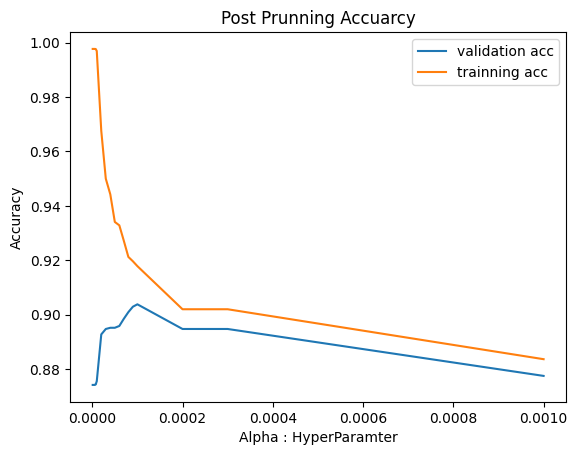

In [1300]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(X_axis_data,val_accuracy_data,label="validation acc")
ax.plot(X_axis_data,train_accuracy_data,label="trainning acc")
ax.set_xlabel("Alpha : HyperParamter")
ax.set_ylabel("Accuracy")
ax.set_title("Post Prunning Accuarcy")
ax.legend()
plt.show()

In [1302]:
print(max(val_accuracy_data))

0.9038036267138434


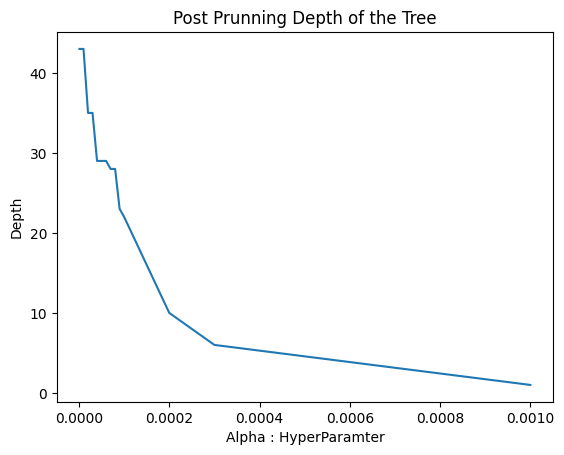

In [1284]:
fig,ax=plt.subplots()
ax.plot(X_axis_data,depth_data,label="Depth")
ax.set_xlabel("Alpha : HyperParamter")
ax.set_ylabel("Depth")
ax.set_title("Post Prunning Depth of the Tree")
plt.show()

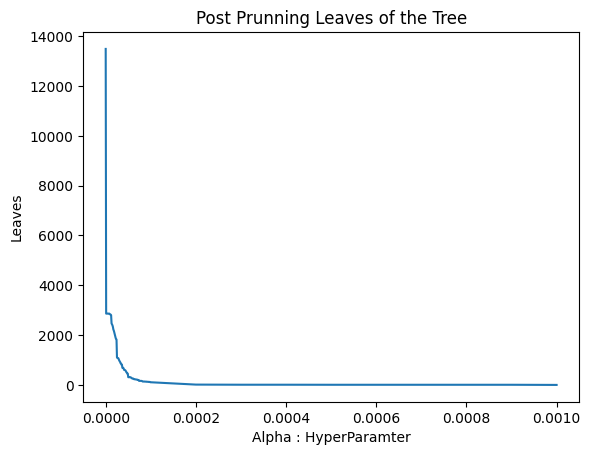

In [1257]:
fig,ax=plt.subplots()
ax.plot(X_axis_data,count_leaves_data,label="Leaves")
ax.set_xlabel("Alpha : HyperParamter")
ax.set_ylabel("Leaves")
ax.set_title("Post Prunning Leaves of the Tree")
plt.show()

In [1304]:
l=[val_evaluation_data[j][2] for j in range (len(X_axis_data))]
print(max(l))

0.5464025026068822


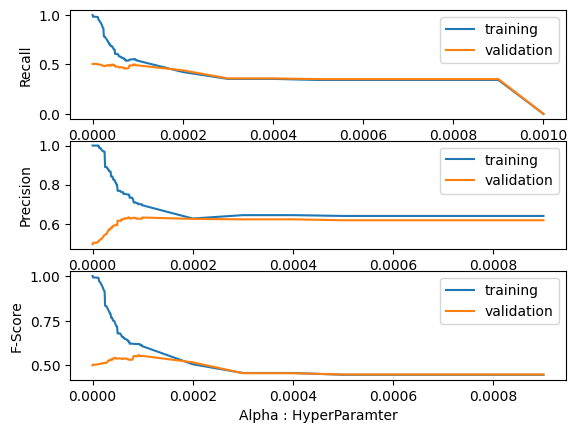

In [1258]:
fig,l=plt.subplots(3)
for i in range (0,3):
    l[i].plot(X_axis_data,[train_evaluation_data[j][i] for j in range (len(X_axis_data))],label="training")
    l[i].plot(X_axis_data,[val_evaluation_data[j][i] for j in range (len(X_axis_data))],label="validation")
    l[i].set_xlabel("Alpha : HyperParamter")
    l[i].legend()
l[0].set_ylabel("Recall")
l[1].set_ylabel("Precision")
l[2].set_ylabel("F-Score")
plt.show()

## K-Fold Validation on the Depth and HyperParameter

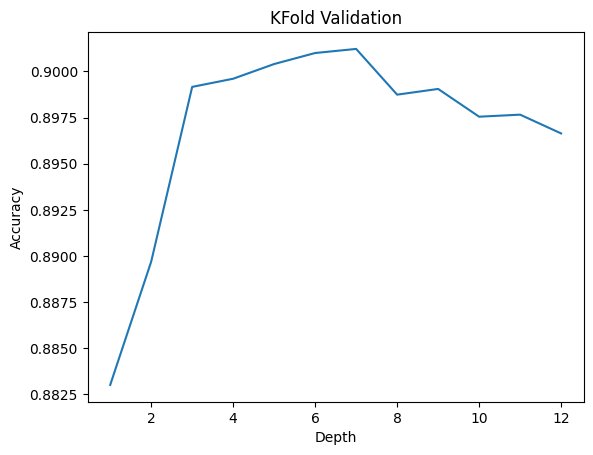

In [1306]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

accuracy_data=[]
# f_score_data=[]

def k_fold_validation(n_splits,max_depth):
    kf=KFold(n_splits=n_splits,shuffle=True)
    for depth in range(1,max_depth+1):
        accuracy_per_depth=0
        f_score_per_depth=0

        for train_index,val_index in kf.split(X):
            X_train_temp,y_train_temp=X.iloc[train_index],y[train_index]
            X_val_temp,y_val_temp=X.iloc[val_index],y[val_index]
            decision_tree=Decision_Tree(depth,1,"entropy")
            Node=TreeNode(X_train_temp,y_train_temp, entropy_cal(y_train_temp))
            decision_tree.make_tree(Node,1,len(Node.X))
            accuracy_per_depth+=(decision_tree.accuracy(X_val_temp,y_val_temp,Node))
            # f_score_per_depth+=(decision_tree.model_evaluate(X_val,y_val,Node)[2])

        accuracy_data.append(accuracy_per_depth/n_splits)
        # f_score_data.append(f_score_per_depth/n_splits)

    fig,ax=plt.subplots()
    X_data=[i for i in range (1,max_depth+1)]
    ax.plot(X_data, accuracy_data)
    # ax.plot(X_data,f_score_data)
    ax.set_xlabel("Depth")
    ax.set_ylabel("Accuracy")
    ax.set_title("KFold Validation")
    plt.show()

k_fold_validation(4,12)

In [1327]:
## Implementing the K-fold for the alpha paramter to find the appropriate alpha
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tqdm import tqdm

val_accuracy_datas=[]
train_accuracy_datas=[]
kf=KFold(n_splits=4,shuffle=True)
alphas=[i *(1e-6) for i in range (1,10)]+[i*(1e-5) for i in range (1,10)]+ [i*1e-4 for i in range (1,4)]+[0.1]

for train_index,val_index in kf.split(X):
    X_temp_train,y_temp_train=X.loc[train_index],y[train_index]
    X_temp_val,y_temp_val=X.loc[val_index],y[val_index]
    decision_tree=Decision_Tree(40,2,"entropy")
    Node=TreeNode(X_temp_train,y_temp_train,entropy_cal(y_temp_train))
    decision_tree.make_tree(Node,1,len(Node.X))
    decision_tree.fit(Node)
    val_accuracy_data=[]
    train_accuracy_data=[]

    for i in tqdm(alphas):
        decision_tree.prune(Node,alpha=i)
        decision_tree.fit(Node)
        val_accuracy_data.append(decision_tree.accuracy(X_temp_val,y_temp_val,Node))
        train_accuracy_data.append(decision_tree.accuracy(X_temp_train,y_temp_train,Node))
    val_accuracy_datas.append(val_accuracy_data)
    train_accuracy_datas.append(train_accuracy_data)

mean_val_accuracy = np.mean(val_accuracy_datas, axis=0)
mean_train_accuracy = np.mean(train_accuracy_datas, axis=0)

  0%|          | 0/22 [00:00<?, ?it/s]0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
100%|██████████| 22/22 [00:26<00:00,  1.22s/it]


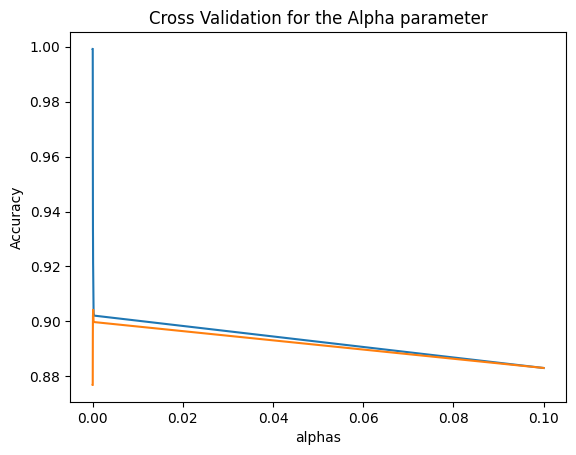

In [1328]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(alphas,mean_train_accuracy, label="trainning alpha")
ax.plot(alphas,mean_val_accuracy, label="validation")
ax.set_xlabel("alphas")
ax.set_ylabel("Accuracy")
ax.set_title("Cross Validation for the Alpha parameter")
plt.show()

## Generating the Final Test Answers


In [1353]:
decision_tree=Decision_Tree(8,2, "entropy")
Node=TreeNode(X,y,entropy_cal(y))
decision_tree.make_tree(Node,1,len(Node.X))
decision_tree.fit(Node)
decision_tree.prune(Node,9e-5) 
print(decision_tree.accuracy(X_val,y_val,Node))

0.9086687306501547


In [1354]:
test_df=pd.read_excel("Test.xlsx")
result=[]
for i in range (0,len(test_df)):
    result.append(decision_tree.prediction(Node,test_df.iloc[i]))
result_df = pd.DataFrame(result, columns=["y"])
result_df.to_csv("result.csv")